# 專案介紹

本專案以勞動基準法違規裁罰資料為分析對象，透過資料探勘方法探索違規法條之間的共現關係與重複違規行為的時間結構。分析流程涵蓋資料前處理、非排序與排序 Pattern Mining，並在此基礎上進一步進行延伸分析，以驗證所辨識之違規模式是否對應實際的行為結構。

本章節將先說明本專案的分析目標與研究動機，並介紹所使用之資料來源與資料結構，作為後續分析流程的背景說明。

## 分析目標與研究問題

在取得勞動基準法違規裁罰資料後，首先檢視資料所涵蓋之欄位內容，評估其分析潛力與適用的分析方法。整體而言，資料中具備明確分析價值的主要欄位為「違法法規法條」與「罰鍰金額」。然而，進一步檢視後發現，罰鍰金額欄位在部分較早期資料中存在缺失值，且罰鍰金額本身亦可能受行政裁量、代理負責人等因素影響，未必能直接反映實際違規行為的結構特性，因此不適合作為本研究的主要分析核心。

相較之下，「違法法規法條」欄位完整記錄了同一事業單位或負責人於不同時間點所違反之法規內容，且同一法條可能在同一負責人下重複出現，具備高度重複性與組合性。基於此，本研究將分析重心聚焦於該欄位，探討是否存在特定法規經常被同時或連續違反的情形。

具體而言，本研究關注以下幾個核心問題：  
(1) 是否存在特定法規，經常與其他法規一同出現在同一負責人的違規紀錄中？  
(2) 若納入時間順序考量，是否可觀察到違規法條之間具有穩定的先後出現模式？  
(3) 這些被連帶或重複違反的法規，是否能形成具有解釋意義的違規行為結構？

由於資料規模龐大，原始資料筆數超過六萬筆，且違規法條組合形式多樣，若以人工方式進行整理與歸納將不具可行性，因此本研究採用資料探勘方法進行分析。具體而言，透過 Pattern Mining 技術，先在不考慮時間順序的情況下探索違規法條之共現模式，再進一步結合時間資訊，分析違規行為在序列層級上的重複與延續結構。期望藉由此一分析流程，揭示違規法條之間潛藏的結構關係，並作為後續延伸分析的基礎。

## 資料介紹

本研究使用之資料來源為政府資料開放平台，資料內容為勞動基準法違規裁罰案件紀錄。資料期間自 2011 年 11 月 15 日起，至 2024 年 7 月 5 日止，涵蓋超過十年以上之違規紀錄。原始資料共包含 63,840 筆觀測值，並依處分日期排序，具備良好的時間序列結構，適合進行跨時間之行為分析。

資料共包含 9 個欄位，各欄位說明如下：

1. **主管機關**：負責處理該違規案件之政府機構。  
2. **公告日期**：該違規案件對外公開公告之日期。  
3. **處分日期**：實際作成行政處分之日期，亦為本研究進行時間順序分析時所依據之主要時間欄位。  
4. **處分字號**：該案件之唯一識別編號。  
5. **事業單位名稱或負責人**：遭裁罰之事業單位名稱或負責人姓名，作為區分不同違規主體之依據。  
6. **違法法規法條**：具體記錄該案件所違反之法規與條文內容，為本研究進行 Pattern Mining 的主要分析欄位。  
7. **違反法規內容**：對違規行為之文字描述，說明實際違反法規之情形。  
8. **罰鍰金額**：該案件所處以之罰鍰金額。需注意的是，資料中自處分日期 2020 年 6 月 12 日起才開始系統性記錄罰鍰金額，較早期資料存在缺失值。  
9. **備註說明**：補充說明欄位，用以記錄其他相關資訊。

整體而言，本資料具備筆數多、違規紀錄重複性高，以及法規條文組合多樣等特性，尤其「違法法規法條」欄位能反映同一事業單位或負責人在不同時間點的多次違規行為，適合用以探討違規法條之共現模式與重複違規結構，亦為本研究後續資料前處理與 Pattern Mining 分析的核心資料來源。

# 資料前處理

在進行 Pattern Mining 分析之前，先對原始資料進行結構檢視與必要的清理與轉換。本節首先檢視資料的欄位結構與基本內容，確認資料品質與可用性，作為後續前處理流程的基礎。

In [ ]:
import pandas as pd

data_dir = '../Data/'
df = pd.read_csv(data_dir + '違反勞動法.csv')

In [2]:
print(df)

                   主管機關      公告日期      處分日期               處分字號  \
0      國家科學及技術委員會新竹科學園區  20240705  20240702    竹環字第1130021878號   
1                   台東縣  20240628  20240628   府社勞字第1130140953號   
2      國家科學及技術委員會新竹科學園區  20240705  20240628    竹環字第1130021283號   
3      國家科學及技術委員會新竹科學園區  20240705  20240628    竹環字第1130021283號   
4                   澎湖縣  20240627  20240627   府社勞字第1131207817號   
...                 ...       ...       ...                ...   
63835               台北市  20111115  20111021  府勞動字第10037904500號   
63836               台北市  20111115  20111019  府勞動字第10040171000號   
63837               台北市  20111115  20111019  府勞動字第10040188400號   
63838               台北市  20111115  20111018  府勞動字第10040195400號   
63839               台北市  20111115  20111012  府勞動字第10037067800號   

                     事業單位名稱或負責人                     違法法規法條  \
0      飛虹國際整合行銷公關顧問股份有限公司(謝銘杰 )               勞動基準法第24條第1項   
1               曹克農君即臺東縣私立鴻德幼兒園               勞動基準法第30條第6項   
2             全安安全工程股

In [3]:
df['違法法規法條'].value_counts()

違法法規法條
勞動基準法第24條                                              5612
勞動基準法第30條第6項                                           4099
勞動基準法第32條第2項                                           4012
勞動基準法第22條第2項                                           3196
勞基法第32條第2項                                             2729
                                                       ... 
勞基法第24條第2項;勞基法第32條第2項;勞基法第36條第1項;勞基法第38條第4項               1
勞動基準法第23條;勞動基準法第24條;勞動基準法第36條                             1
勞動基準法第23條第2項;勞動基準法第36條第1項;勞動基準法第38條第5項                    1
勞動基準法第22條第2項;勞動基準法第32條第1項;勞動基準法第49條第1項;勞動基準法第36條第1項       1
勞動基準法第7條第1項;勞動基準法第22條第2項;勞動基準法第30條第1項                     1
Name: count, Length: 2960, dtype: int64

**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 本研究進行之目標為「違反法規法條」之 Pattern Mining。在資料讀入後，首先需保留後續分析所需的關鍵欄位，並對其進行必要的標準化處理，以確保資料的一致性與可分析性。

- 「違反法規法條」欄位的紀錄格式相當多樣，包含如「勞基法第30條第6項」、「勞動基準法第23條第一項」等不同呈現方式，亦可能出現輸入錯誤的情形，例如「勞動基準法勞動基準法第21條第1項」。因此，後續需對此欄位進行格式統一與內容清理，以確保違規項目的辨識與後續模式探勘的準確性。

**<font color=seagreen>接著要進行的步驟:</font>**

- 統一法規名稱格式，將「勞動基準法」與「勞基法」一律標準化為「勞基法」。

- 簡化法條表示方式，將「第23條第1項」等格式統一調整為「第23條」。

- 將同一員工於同一時間點違反的多個法條以「,」進行分隔。

- 移除誤植或格式錯誤的紀錄，確保此欄位內容均維持為標準化之「勞基法第X條」格式。

<font color=mediumseagreen>將「違反法規法條」欄位中以「;」或「。」分隔的多筆紀錄拆分為獨立列，其餘資料維持原狀。</font>

In [4]:
df_expanded = df.assign(
    違法法規法條=df['違法法規法條'].str.split(';')
).explode(['違法法規法條']).reset_index(drop=True)
for i in range(len(df_expanded) - 1):
    if '。' in df_expanded.at[i, '違反法規內容']:
        parts = df_expanded.at[i, '違反法規內容'].split('。')
        df_expanded.at[i, '違反法規內容'] = parts[0] + '。'
        df_expanded.at[i + 1, '違反法規內容'] = parts[1] + df_expanded.at[i + 1, '違反法規內容']
    if ';' in df_expanded.at[i, '違反法規內容']:
        parts = df_expanded.at[i, '違反法規內容'].split(';')
        df_expanded.at[i, '違反法規內容'] = parts[0]
        df_expanded.at[i + 1, '違反法規內容'] = parts[1]

print(df_expanded.head(10))

               主管機關      公告日期      處分日期               處分字號  \
0  國家科學及技術委員會新竹科學園區  20240705  20240702    竹環字第1130021878號   
1               台東縣  20240628  20240628   府社勞字第1130140953號   
2  國家科學及技術委員會新竹科學園區  20240705  20240628    竹環字第1130021283號   
3  國家科學及技術委員會新竹科學園區  20240705  20240628    竹環字第1130021283號   
4               澎湖縣  20240627  20240627   府社勞字第1131207817號   
5               澎湖縣  20240627  20240627   府社勞字第1131207817號   
6               雲林縣  20240701  20240627  府勞動一字第1133418864號   
7               台東縣  20240627  20240627   府社勞字第1130140949號   
8  國家科學及技術委員會新竹科學園區  20240705  20240626    竹環字第1130019920號   
9  國家科學及技術委員會新竹科學園區  20240705  20240626    竹環字第1130021126號   

                 事業單位名稱或負責人        違法法規法條                          違反法規內容  \
0  飛虹國際整合行銷公關顧問股份有限公司(謝銘杰 )  勞動基準法第24條第1項               延長工作時間之工資未依法令標準加給   
1           曹克農君即臺東縣私立鴻德幼兒園  勞動基準法第30條第6項        前項出勤紀錄，應逐日記載勞工出勤情形至分鐘為止。   
2         全安安全工程股份有限公司(魏吳晉)  勞動基準法第32條第2項  延長勞工之工作時間，一日超過12小時，且一個月超過46小時。   
3        

<font color=mediumseagreen>檢視「違法法規法條」欄位涵蓋的所有類別，以確認其完整性與資料分布。</font>

In [5]:
class_counts = df_expanded['違法法規法條'].value_counts()
print(class_counts)

違法法規法條
勞動基準法第24條            9594
勞動基準法第32條第2項         7673
勞動基準法第30條第6項         6204
勞動基準法第22條第2項         5369
勞動基準法第39條            4639
                     ... 
勞基法 第32條第2項             1
勞動基準法第24條第2項            1
勞動基準法 第24條第1項           1
勞基法第51條                 1
勞動基準法勞動基準法第21條第1項       1
Name: count, Length: 268, dtype: int64


<font color=mediumseagreen>統一法條紀錄格式，使所有違法紀錄皆呈現為「勞基法第X條」。</font>

In [6]:
df_expanded['違法法規法條'] = df_expanded['違法法規法條'].str.replace('勞動基準法', '勞基法')
df_expanded['違法法規法條'] = df_expanded['違法法規法條'].str.replace(' ', '')
df_expanded['違法法規法條'] = df_expanded['違法法規法條'].str.replace(r'(勞基法)(?=.*\1)', '', regex=True)
df_expanded['違法法規法條'] = df_expanded['違法法規法條'].str.rstrip('勞基法')
df_expanded['違法法規法條'] = df_expanded['違法法規法條'].apply(lambda x: '勞基法' + x if '勞基法' not in x else x)
df_expanded['違法法規法條'] = df_expanded['違法法規法條'].apply(lambda x: '勞基法' + x.replace('勞基法', '') if not x.startswith('勞基法') else x)
df_expanded['違法法規法條'] = df_expanded['違法法規法條'].str.replace(r'條.*', '條', regex=True)
df_expanded['違法法規法條'] = df_expanded['違法法規法條'].str.replace(r'-.*', '條', regex=True)
print(df_expanded.head(10))

               主管機關      公告日期      處分日期               處分字號  \
0  國家科學及技術委員會新竹科學園區  20240705  20240702    竹環字第1130021878號   
1               台東縣  20240628  20240628   府社勞字第1130140953號   
2  國家科學及技術委員會新竹科學園區  20240705  20240628    竹環字第1130021283號   
3  國家科學及技術委員會新竹科學園區  20240705  20240628    竹環字第1130021283號   
4               澎湖縣  20240627  20240627   府社勞字第1131207817號   
5               澎湖縣  20240627  20240627   府社勞字第1131207817號   
6               雲林縣  20240701  20240627  府勞動一字第1133418864號   
7               台東縣  20240627  20240627   府社勞字第1130140949號   
8  國家科學及技術委員會新竹科學園區  20240705  20240626    竹環字第1130019920號   
9  國家科學及技術委員會新竹科學園區  20240705  20240626    竹環字第1130021126號   

                 事業單位名稱或負責人   違法法規法條                          違反法規內容  \
0  飛虹國際整合行銷公關顧問股份有限公司(謝銘杰 )  勞基法第24條               延長工作時間之工資未依法令標準加給   
1           曹克農君即臺東縣私立鴻德幼兒園  勞基法第30條        前項出勤紀錄，應逐日記載勞工出勤情形至分鐘為止。   
2         全安安全工程股份有限公司(魏吳晉)  勞基法第32條  延長勞工之工作時間，一日超過12小時，且一個月超過46小時。   
3         全安安全工程股份有限公司(魏吳晉)  

<font color=mediumseagreen>檢視經標準化後的法條紀錄，確認資料中涉及哪些條文。</font>

In [7]:
class_counts = df_expanded['違法法規法條'].value_counts()
print(class_counts)

違法法規法條
勞基法第24條    17857
勞基法第30條    12032
勞基法第32條    11870
勞基法第36條    10225
勞基法第22條     6613
勞基法第39條     5706
勞基法第23條     4552
勞基法第38條     3994
勞基法第21條     2116
勞基法第80條     1992
勞基法第59條      977
勞基法第34條      941
勞基法第35條      742
勞基法第70條      718
勞基法第37條      677
勞基法第49條      552
勞基法第56條      430
勞基法第43條      375
勞基法第7條       274
勞基法第9條       203
勞基法第27條      201
勞基法第16條      166
勞基法第28條       78
勞基法第46條       63
勞基法第55條       53
勞基法第19條       38
勞基法第13條       37
勞基法第50條       30
勞基法第40條       30
勞基法第17條       27
勞基法第26條       22
勞基法第74條       21
勞基法第65條       12
勞基法第68條        4
勞基法第51條        2
勞基法第33條        1
勞基法第83條        1
勞基法第12條        1
勞基法第25條        1
Name: count, dtype: int64


<font color=mediumseagreen>保留後續分析所需之欄位，並依負責人與處分日期排序；再將相同負責人與同一處分日期的多筆法條資訊合併，並以「,」進行分隔。</font>

In [ ]:
df_grouped = (
    df_expanded
    [['事業單位名稱或負責人', '處分日期', '違法法規法條']] 
    .sort_values(['事業單位名稱或負責人', '處分日期'])       
    .groupby(['事業單位名稱或負責人', '處分日期'])['違法法規法條']
    .apply(lambda x: ','.join(x))                   
    .reset_index()
)

In [9]:
print(df_grouped)

                         事業單位名稱或負責人      處分日期  \
0              &#18962;霏數位有限公司(曾鵬宇)  20170620   
1      &#2013268056;師傅企業股份有限公司(林志勳)  20191017   
2       &#20338;&#23791;貿易有限公司(翁世勇)  20160826   
3       &#20338;&#23791;貿易有限公司(翁世勇)  20161221   
4               &#20453;亭停車事業股份有限公司  20191029   
...                             ...       ...   
54515            龔玲慧即臺北市私立豐橋美語短期補習班  20150325   
54516                     龔銘凱即忠達工程行  20210107   
54517                      龔麗黛即永安藥局  20161111   
54518                 龜派餐飲有限公司(曾玉彰)  20201102   
54519             亭停車事業股份有限公司(陳文俊)  20210819   

                                        違法法規法條  
0                                      勞基法第22條  
1                                      勞基法第24條  
2                                      勞基法第30條  
3                                      勞基法第30條  
4      勞基法第24條,勞基法第30條,勞基法第32條,勞基法第36條,勞基法第39條  
...                                        ...  
54515                                  勞基法第30條  
54516              

<font color=mediumseagreen>為後續進行不考慮順序的 Pattern Mining，建立一份移除處分日期欄位的資料版本。</font>

In [10]:
dfnew = (df_grouped
        .groupby('事業單位名稱或負責人')['違法法規法條']
        .apply(lambda x: ','.join(x))
        .reset_index()
        )

In [11]:
print(dfnew)

                         事業單位名稱或負責人                                   違法法規法條
0              &#18962;霏數位有限公司(曾鵬宇)                                  勞基法第22條
1      &#2013268056;師傅企業股份有限公司(林志勳)                                  勞基法第24條
2       &#20338;&#23791;貿易有限公司(翁世勇)                          勞基法第30條,勞基法第30條
3               &#20453;亭停車事業股份有限公司  勞基法第24條,勞基法第30條,勞基法第32條,勞基法第36條,勞基法第39條
4          &#20453;亭停車事業股份有限公司(陳文俊)                  勞基法第43條,勞基法第32條,勞基法第36條
...                             ...                                      ...
41827            龔玲慧即臺北市私立豐橋美語短期補習班                                  勞基法第30條
41828                     龔銘凱即忠達工程行                                  勞基法第59條
41829                      龔麗黛即永安藥局                                  勞基法第36條
41830                 龜派餐飲有限公司(曾玉彰)                          勞基法第32條,勞基法第36條
41831             亭停車事業股份有限公司(陳文俊)                                  勞基法第22條

[41832 rows x 2 columns]


In [12]:
dfnew['違法法規法條'].value_counts()

違法法規法條
勞基法第30條                                                                                                                                                                                                                                           4828
勞基法第24條                                                                                                                                                                                                                                           4151
勞基法第36條                                                                                                                                                                                                                                           2323
勞基法第32條                                                                                                                                                                                                                                           2252
勞基法第2

# Pattern Mining 分析
本研究的樣式探勘將分為兩部分進行：非排序資料與排序資料。

- 非排序資料主要使用 Apriori 與 FP-growth 探勘關聯規則。

- 排序資料則使用 PrefixSpan 探勘序列模式。

以下將分別說明分析方法與後續進行的內容。

## 非排序資料之 Pattern Mining

本階段將針對不考慮事件順序的資料進行關聯規則探勘，並採用 Apriori 與 FP-growth 兩種演算法。分析流程如下：

- **Apriori**  
  - 探勘設定採用三組最小支持度（0.005、0.01、0.05）與兩組最小信賴度（0.6、0.8），進行交叉比對。

  - 比較不同參數組合下所生成的規則與其特性。

- **FP-growth**  
  - 使用與 Apriori 相同的支持度與信賴度設定。
  
  - 分析 FP-growth 所產生的規則，並比較其與 Apriori 的差異。

接著將觀察兩種演算法在不同參數組合下所得結果的異同，作為後續解讀的基礎。

<font color=mediumseagreen>將資料轉換成進行 Apriori 及 FP-Growth 所需的資料型態</font>

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

transactions = dfnew['違法法規法條'].apply(lambda x: x.split(','))

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_array, columns=te.columns_)

### Apriori（最小支持度 = 0.005）

In [14]:
frequent_itemsets_s0005 = apriori(transaction_df, min_support=0.005, use_colnames=True)

#### 產生關聯規則（信賴度 = 0.6）

In [ ]:
rules_s0005_c06 = association_rules(frequent_itemsets_s0005, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets_s0005))
print("\n關聯規則：")
print(rules_s0005_c06)


關聯規則：
                    antecedents consequents  antecedent support  \
0            (勞基法第21條, 勞基法第32條)   (勞基法第24條)            0.008486   
1            (勞基法第21條, 勞基法第36條)   (勞基法第24條)            0.009132   
2            (勞基法第21條, 勞基法第39條)   (勞基法第24條)            0.008893   
3            (勞基法第32條, 勞基法第22條)   (勞基法第24條)            0.023618   
4            (勞基法第36條, 勞基法第22條)   (勞基法第24條)            0.027802   
5            (勞基法第22條, 勞基法第39條)   (勞基法第24條)            0.020463   
6            (勞基法第32條, 勞基法第23條)   (勞基法第24條)            0.011737   
7            (勞基法第23條, 勞基法第39條)   (勞基法第24條)            0.009227   
8            (勞基法第30條, 勞基法第32條)   (勞基法第24條)            0.030192   
9            (勞基法第32條, 勞基法第38條)   (勞基法第24條)            0.018096   
10           (勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.027539   
11           (勞基法第38條, 勞基法第36條)   (勞基法第24條)            0.020750   
12           (勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.041475   
13           (勞基法第38條, 勞基法第39條)   (勞基法第24條)            

**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 本次分析共有 41,832 筆資料，因此先採用較低的最小支持度（min_support = 0.005）。在此設定下，凡支持度超過約 209 筆的項目組（itemsets）會被保留下來。

- 最小信賴度（min_confidence）設定為 0.6，旨在篩選具較強關聯性的規則（association rules）。

- 在上述條件下，共產生 24 組關聯規則。所有規則的後件（consequent）皆為「勞基法第24條」，顯示第24條與其他法條之間具有顯著的關聯性。

- 觀察結果顯示，各關聯規則的項目數量皆為 3 項以上，意味著違反第24條的案件，往往同時伴隨多條法條的違反行為。

- 所得規則的 lift 值均大於 1.7，表示這些法條與「勞基法第24條」之間具有正向共現關係，違規行為同時發生的機率遠高於隨機情況。

#### 產生關聯規則（信賴度 = 0.8）

In [ ]:
rules_s0005_c08 = association_rules(frequent_itemsets_s0005, metric="confidence", min_threshold=0.8, num_itemsets=len(frequent_itemsets_s0005))
print("\n關聯規則：")
print(rules_s0005_c08)


關聯規則：
                   antecedents consequents  antecedent support  \
0           (勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.027539   
1  (勞基法第32條, 勞基法第22條, 勞基法第39條)   (勞基法第24條)            0.006526   
2  (勞基法第36條, 勞基法第22條, 勞基法第39條)   (勞基法第24條)            0.009873   
3  (勞基法第30條, 勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.007291   
4  (勞基法第32條, 勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.014415   
5  (勞基法第32條, 勞基法第38條, 勞基法第39條)   (勞基法第24條)            0.005809   

   consequent support   support  confidence      lift  representativity  \
0            0.349421  0.022112    0.802951  2.297945               1.0   
1            0.349421  0.005881    0.901099  2.578831               1.0   
2            0.349421  0.007913    0.801453  2.293656               1.0   
3            0.349421  0.006287    0.862295  2.467779               1.0   
4            0.349421  0.012311    0.854063  2.444220               1.0   
5            0.349421  0.005211    0.897119  2.567442               1.0   

   l

**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 在最小支持度維持 0.005 的條件下，將最小信賴度（min_confidence）提高至 0.8，以觀察在更嚴格的關聯性門檻下所產生的規則變化。

- 所得關聯規則的數量由原先的 24 組下降至 6 組，顯示較高的信賴度門檻大幅縮減可保留的規則。然而，所有規則的後件仍一致為「勞基法第24條」，規則核心結構並未改變。

- 在支持度方面，並未因信賴度提高而集中於更高支持度的規則；部分支持度較低的項目組仍被保留下來，顯示在較高信賴度條件下，支持度並非規則淘汰的主要影響因素。

- 規則的前件（antecedent）主要集中於「勞基法第22條、第32條、第36條、第39條」，但仍可見較少量的其他法條，例如「第30條」與「第38條」。

- 規則項目數方面，若將前件與後件一併計算，所得規則包含 1 組 3 項組合以及 4 組 4 項組合，與信賴度 0.6 時的結果相近，皆主要分布於 3 至 4 項之間，項目組成並未因信賴度提高而出現明顯結構變化。

- 被保留下來的規則之 lift 值均高於 2.25，顯示在更嚴格的信賴度條件下，規則仍具明顯的正向共現關係。

#### Confidence（0.6 vs 0.8）的比較

##### 1. 可產生規則的數量變化

- confidence = 0.6：可產生 24 組關聯規則。

- confidence = 0.8：規則減少至 6 組，顯示信賴度提高後規則數量大幅下降。

較高信賴度具有更強的篩選效果，規則數量明顯減少。

##### 2. 後件的穩定性

- confidence = 0.6：所有規則後件皆為「勞基法第24條」。

- confidence = 0.8：後件仍完全一致為第24條。

信賴度調整不影響後件結構，規則核心維持高度穩定。

##### 3. 前件法條的組成變化

- confidence = 0.6：前件涵蓋第21條、22條、23條、30條、32條、36條、38條與39條等多項法條。

- confidence = 0.8：前件收斂至第22條、32條、36條與39條，僅少量保留第30條及第38條。

提高信賴度後，前件法條種類明顯收斂。

##### 4. 規則的項目數（rule length）

- confidence = 0.6：規則主要集中於 3 至 4 項組合。

- confidence = 0.8：規則仍以 3 至 4 項為主，未出現結構性變化。

信賴度提升未改變規則複雜度，項目數分布維持一致。

##### 5. 共現強度（lift）

- confidence = 0.6：lift 多高於約 1.7。

- confidence = 0.8：lift 最小值提升至約 2.25，規則的共現程度更高。

較高信賴度條件下，保留下的規則呈現更強的共現關係。

### Apriori（最小支持度 = 0.01）

In [ ]:
frequent_itemsets_s001 = apriori(transaction_df, min_support=0.01, use_colnames=True)

#### 產生關聯規則（信賴度 = 0.6）

In [ ]:
rules_s001_c06 = association_rules(frequent_itemsets_s001, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets_s001))
print("\n關聯規則：")
print(rules_s001_c06)


關聯規則：
                   antecedents consequents  antecedent support  \
0           (勞基法第32條, 勞基法第22條)   (勞基法第24條)            0.023618   
1           (勞基法第36條, 勞基法第22條)   (勞基法第24條)            0.027802   
2           (勞基法第22條, 勞基法第39條)   (勞基法第24條)            0.020463   
3           (勞基法第30條, 勞基法第32條)   (勞基法第24條)            0.030192   
4           (勞基法第32條, 勞基法第38條)   (勞基法第24條)            0.018096   
5           (勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.027539   
6           (勞基法第38條, 勞基法第36條)   (勞基法第24條)            0.020750   
7           (勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.041475   
8           (勞基法第38條, 勞基法第39條)   (勞基法第24條)            0.018120   
9  (勞基法第32條, 勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.014415   

   consequent support   support  confidence      lift  representativity  \
0            0.349421  0.017092    0.723684  2.071092               1.0   
1            0.349421  0.017570    0.631986  1.808664               1.0   
2            0.349421  0.014391    0.7032

**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 在最小支持度 0.01、最小信賴度 0.6 的條件下，共產生 10 組關聯規則，相較於 min_support = 0.005 時的結果，規則數量明顯減少。

- 所有規則的後件皆為「勞基法第24條」，顯示在不同支持度設定下，規則的核心後件結構維持一致，未出現新的共同後件項目。

- 規則的前件主要由勞基法第22條、第30條、第32條、第36條、第38條與第39條組成，與 min_support = 0.005 時的前件分布大致相同，但第21條與第23條未再出現，呈現較為收斂且穩定的前件結構。

- 規則的項目數分布集中於 3 至 4 項，其中 9 組由 3 個項目構成，另有 1 組由 4 個項目構成，與較低支持度下常見的 3–4 項模式相符，未出現明顯的項目數變化。

- 所得規則的 lift 值均高於約 1.78，皆呈現正向共現關係。

- 整體而言，提高支持度後，規則數量雖然下降，但前件、後件與項目數的整體結構仍維持高度一致，規則模式在此支持度範圍內具有明顯穩定性。

#### 產生關聯規則（信賴度 = 0.8）

In [ ]:
rules_s001_c08 = association_rules(frequent_itemsets_s001, metric="confidence", min_threshold=0.8, num_itemsets=len(frequent_itemsets_s001))
print("\n關聯規則：")
print(rules_s001_c08)


關聯規則：
                   antecedents consequents  antecedent support  \
0           (勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.027539   
1  (勞基法第32條, 勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.014415   

   consequent support   support  confidence      lift  representativity  \
0            0.349421  0.022112    0.802951  2.297945               1.0   
1            0.349421  0.012311    0.854063  2.444220               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0  0.012490    3.301614       0.580824  0.062315   0.697118    0.433117  
1  0.007274    4.457941       0.599513  0.035022   0.775681    0.444648  


**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 在最小支持度 0.01 且最小信賴度提升至 0.8 的條件下，共產生 2 組關聯規則，規則數量相較於 min_confidence = 0.6 時的 10 組明顯下降，顯示信賴度門檻在此支持度設定下仍具有強烈的篩選效果。

- 所有規則的後件皆為「勞基法第24條」，後件結構在不同信賴度條件下完全一致，規則核心未隨信賴度變動而改變。

- 規則的前件分別為（勞基法第39條、第32條）與（勞基法第39條、第32條、第36條），呈現較高支持度與較高信賴度下的收斂現象；與 min_confidence = 0.6 相比，前件所涉及的法條種類明顯減少。

- 兩組規則的 lift 值分別為 2.29 與 2.44，皆大於 1，顯示規則具有明顯的正向共現關係。

- 若將前件與後件視為完整項目組，兩組規則的項目數分別為 3 項與 4 項，項目數分布與信賴度 0.6 時相近，未出現明顯的規則複雜度變動。

#### Confidence（0.6 vs 0.8）的比較

##### 1. 可產生規則的數量變化

- confidence = 0.6：可產生 10 組關聯規則。

- confidence = 0.8：僅剩 2 組規則。

信賴度提高後規則數量大幅減少，篩選效果顯著。

##### 2. 後件的穩定性

- confidence = 0.6：所有規則後件皆為「勞基法第24條」。

- confidence = 0.8：後件同樣固定為第24條。

後件在不同信賴度條件下維持完全一致。

##### 3. 前件法條的組成變化

- confidence = 0.6：前件涵蓋第22條、第30條、第32條、第36條、第38條與第39條等多項法條。

- confidence = 0.8：前件收斂為第39條、第32條（及第36條）的組合。

信賴度提高使前件種類明顯縮減。

##### 4. 規則的項目數

- confidence = 0.6：9 組為 3 項、1 組為 4 項。

- confidence = 0.8：1 組為 3 項、1 組為 4 項。

規則項目數在兩種信賴度下皆集中於 3 至 4 項，結構穩定。

##### 5. 共現強度

- confidence = 0.6：lift 最小值約為 1.78。

- confidence = 0.8：lift 分別為 2.29 與 2.44，呈現更強的共現性。

提升信賴度後，所保留下的規則皆具有更高的共現程度。


### Apriori（最小支持度 = 0.05）

In [20]:
frequent_itemsets_s005 = apriori(transaction_df, min_support=0.05, use_colnames=True)

#### 產生關聯規則（信賴度 = 0.6）

In [ ]:
rules_s005_c06 = association_rules(frequent_itemsets_s005, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets_s005))
print("\n關聯規則：")
print(rules_s005_c06)


關聯規則：
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


#### 產生關聯規則（信賴度 = 0.8）

In [ ]:
rules_s005_c08 = association_rules(frequent_itemsets_s005, metric="confidence", min_threshold=0.8, num_itemsets=len(frequent_itemsets_s005))
print("\n關聯規則：")
print(rules_s005_c08)


關聯規則：
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 在最小支持度設定為 0.05 的情況下，未產生任何頻繁項目集（frequent itemsets）。由先前結果可知，在 min_support = 0.005 時，最大的項目集支持度約為 0.029，而最大前件支持度約為 0.027，均遠低於 0.05 的門檻，因此無法生成任何符合條件的項目集屬於預期結果。

- 由於未能產生頻繁項目集，進一步的關聯規則亦無法形成，因此在 min_support = 0.05 下，不論最小信賴度設定為 0.6 或 0.8，最終結果皆為無規則輸出。

- 整體而言，在此支持度門檻下，資料中沒有任何項目集的出現比例足以滿足條件，因此本設定下未獲得任何可供觀察的關聯模式。

### Apriori：不同支持度（min_support）的比較

#### 1. 可產生規則的數量變化

- 在較低的支持度設定下能生成最多的規則。

- 隨著 min_support 提高，可產生的規則數量明顯減少。

- 當支持度提高至較高門檻時，資料中已沒有任何項目集能滿足最低出現比例，因此無法產生規則。

隨支持度提高，可生成的規則逐步減少，最終可能完全無規則。

#### 2. 後件的穩定性

- 在所有可產生規則的支持度設定下，後件皆固定為「勞基法第24條」。

- 支持度提高並未造成後件變動，也未引入其他法條作為後件。

後件呈現高度一致性，規則中心不受支持度變化影響。

#### 3. 前件法條的組成變化

- 在較低支持度下，前件涵蓋的法條種類較多。

- 當支持度提高後，前件法條種類逐漸減少，呈現收斂，只保留出現頻率較高的法條。

- 在較高支持度設定下，由於無規則產生，前件組成亦不再存在。

支持度提高使前件法條種類明顯收斂，規則結構逐漸集中。

#### 4. 規則的項目數

- 在可產生規則的支持度範圍內，規則主要由三至四個項目組成。

- 支持度提高並未造成項目數的變動，規則複雜度維持穩定。

- 當支持度高到無法產生規則時，項目數自然不再存在。

項目數在不同支持度下保持一致，規則複雜度未受到支持度的影響。

#### 5. 規則的共現強度

- 在較低支持度下所產生的規則已呈現正向關聯。

- 在較高支持度下（仍可產生規則的範圍內），所保留下的規則通常具有更高的 lift。

- 過高支持度導致無規則，可供觀察的 lift 也不存在。

較高支持度往往留下共現性更強的規則。

### FP-Growth（最小支持度 = 0.005）

In [ ]:
frequent_itemsets_fp_s0005 = fpgrowth(transaction_df, min_support=0.005, use_colnames=True)

#### 產生關聯規則（信賴度 = 0.6）

In [ ]:
rules_fp_s0005_c06 = association_rules(frequent_itemsets_fp_s0005, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets_fp_s0005))
print("\n關聯規則：")
print(rules_fp_s0005_c06)


關聯規則：
                    antecedents consequents  antecedent support  \
0            (勞基法第36條, 勞基法第22條)   (勞基法第24條)            0.027802   
1            (勞基法第32條, 勞基法第22條)   (勞基法第24條)            0.023618   
2   (勞基法第32條, 勞基法第36條, 勞基法第22條)   (勞基法第24條)            0.010399   
3            (勞基法第30條, 勞基法第32條)   (勞基法第24條)            0.030192   
4   (勞基法第30條, 勞基法第32條, 勞基法第36條)   (勞基法第24條)            0.013506   
5            (勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.041475   
6            (勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.027539   
7   (勞基法第32條, 勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.014415   
8   (勞基法第30條, 勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.010542   
9   (勞基法第30條, 勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.007291   
10           (勞基法第22條, 勞基法第39條)   (勞基法第24條)            0.020463   
11  (勞基法第36條, 勞基法第22條, 勞基法第39條)   (勞基法第24條)            0.009873   
12  (勞基法第32條, 勞基法第22條, 勞基法第39條)   (勞基法第24條)            0.006526   
13           (勞基法第32條, 勞基法第23條)   (勞基法第24條)            

**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 在最小支持度 0.005、最小信賴度 0.6 的條件下，FP-Growth 共產生 24 組關聯規則。

- 所得規則的後件皆為「勞基法第24條」，前件涵蓋的法條組合與 Apriori 在相同參數下完全一致。

- 規則的項目數主要落在 3–4 項之間，lift 值均高於約 1.7，呈現明顯正向共現。

- 整體而言，本參數設定下 FP-Growth 的規則結構、前件分布與共現強度均與 Apriori 所得結果相同。

#### 產生關聯規則（信賴度 = 0.8）

In [ ]:
rules_fp_s0005_c08 = association_rules(frequent_itemsets_fp_s0005, metric="confidence", min_threshold=0.8, num_itemsets=len(frequent_itemsets_fp_s0005))
print("\n關聯規則：")
print(rules_fp_s0005_c08)


關聯規則：
                   antecedents consequents  antecedent support  \
0           (勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.027539   
1  (勞基法第32條, 勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.014415   
2  (勞基法第30條, 勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.007291   
3  (勞基法第36條, 勞基法第22條, 勞基法第39條)   (勞基法第24條)            0.009873   
4  (勞基法第32條, 勞基法第22條, 勞基法第39條)   (勞基法第24條)            0.006526   
5  (勞基法第32條, 勞基法第38條, 勞基法第39條)   (勞基法第24條)            0.005809   

   consequent support   support  confidence      lift  representativity  \
0            0.349421  0.022112    0.802951  2.297945               1.0   
1            0.349421  0.012311    0.854063  2.444220               1.0   
2            0.349421  0.006287    0.862295  2.467779               1.0   
3            0.349421  0.007913    0.801453  2.293656               1.0   
4            0.349421  0.005881    0.901099  2.578831               1.0   
5            0.349421  0.005211    0.897119  2.567442               1.0   

   l

**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- FP-Growth 在最小支持度 0.005、最小信賴度 0.8 下共產生 6 組關聯規則，規則數量的下降幅度與 Apriori 完全一致。

- 所有規則的後件固定為「勞基法第24條」，前件組合主要集中於第22條、第32條、第36條與第39條，也與 Apriori 的結果相符。

- 規則項目數集中於 3–4 項，lift 值最低約為 2.25，顯示共現強度較高。

- 整體而言，本參數設定下 FP-Growth 與 Apriori 產生相同的規則組成與特性。

#### Confidence（0.6 vs 0.8）的比較

##### 1. 規則數量

- confidence = 0.6：24 組  

- confidence = 0.8：6 組  

規則數量大幅下降，與 Apriori 的變化幅度一致。

##### 2. 後件結構

- 兩種信賴度下，後件皆固定為「勞基法第24條」。

##### 3. 前件收斂情形

- 0.6：前件涵蓋 21、22、23、30、32、36、38、39 等多項法條。  

- 0.8：前件組合收斂至第22、32、36、39 為主，僅少量搭配 30、38。

##### 4. 規則項目數

- 兩種信賴度下，規則皆以 3–4 項為主。

##### 5. 共現強度

- 0.6：lift 最小值約 1.7。  

- 0.8：lift 最小值約 2.25。  

***信賴度提升使規則數量明顯減少，前件種類集中，但後件與項目數結構維持一致。***

### FP-Growth（最小支持度 = 0.01）

In [ ]:
frequent_itemsets_fp_s001 = fpgrowth(transaction_df, min_support=0.01, use_colnames=True)

#### 產生關聯規則（信賴度 = 0.6）

In [ ]:
rules_fp_s001_c06 = association_rules(frequent_itemsets_fp_s001, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets_fp_s001))
print("\n關聯規則：")
print(rules_fp_s001_c06)


關聯規則：
                   antecedents consequents  antecedent support  \
0           (勞基法第36條, 勞基法第22條)   (勞基法第24條)            0.027802   
1           (勞基法第32條, 勞基法第22條)   (勞基法第24條)            0.023618   
2           (勞基法第30條, 勞基法第32條)   (勞基法第24條)            0.030192   
3           (勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.041475   
4           (勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.027539   
5  (勞基法第32條, 勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.014415   
6           (勞基法第22條, 勞基法第39條)   (勞基法第24條)            0.020463   
7           (勞基法第32條, 勞基法第38條)   (勞基法第24條)            0.018096   
8           (勞基法第38條, 勞基法第36條)   (勞基法第24條)            0.020750   
9           (勞基法第38條, 勞基法第39條)   (勞基法第24條)            0.018120   

   consequent support   support  confidence      lift  representativity  \
0            0.349421  0.017570    0.631986  1.808664               1.0   
1            0.349421  0.017092    0.723684  2.071092               1.0   
2            0.349421  0.018861    0.6247

**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 在最小支持度 0.01、最小信賴度 0.6 的條件下，FP-Growth 共產生 10 組關聯規則，與 Apriori 之結果一致。

- 所有規則後件皆為「勞基法第24條」，前件主要由第22、30、32、36、38、39條等組成，與 Apriori 相同。

- 規則項目數仍以 3–4 項為主，lift 最小值約為 1.78。

- 整體規則結構與 Apriori 完全一致，顯示在此支持度下兩方法挖掘出的共現模式相同。

#### 產生關聯規則（信賴度 = 0.8）

In [ ]:
rules_fp_s001_c08 = association_rules(frequent_itemsets_fp_s001, metric="confidence", min_threshold=0.8, num_itemsets=len(frequent_itemsets_fp_s001))
print("\n關聯規則：")
print(rules_fp_s001_c08)


關聯規則：
                   antecedents consequents  antecedent support  \
0           (勞基法第32條, 勞基法第39條)   (勞基法第24條)            0.027539   
1  (勞基法第32條, 勞基法第36條, 勞基法第39條)   (勞基法第24條)            0.014415   

   consequent support   support  confidence      lift  representativity  \
0            0.349421  0.022112    0.802951  2.297945               1.0   
1            0.349421  0.012311    0.854063  2.444220               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0  0.012490    3.301614       0.580824  0.062315   0.697118    0.433117  
1  0.007274    4.457941       0.599513  0.035022   0.775681    0.444648  


**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- FP-Growth 在最小支持度 0.01、最小信賴度 0.8 下共產生 2 組關聯規則，與 Apriori 在相同參數下所得結果一致。

- 規則後件固定為「勞基法第24條」，前件僅剩第39、32 與第39、32、36 等高頻組合。

- 規則項目數為 3 項與 4 項，lift 分別約為 2.29 與 2.44。

- 本參數設定下 FP-Growth 與 Apriori 的規則收斂程度與共現強度完全相符。

#### Confidence（0.6 vs 0.8）的比較

##### 1. 規則數量

- 0.6：10 組  

- 0.8：2 組  

##### 2. 後件結構

- 兩者後件皆為「勞基法第24條」。

##### 3. 前件收斂情形

- 0.6：前件涵蓋第22、30、32、36、38、39 等多項法條。  

- 0.8：前件僅剩第39、32 與第39、32、36 的組合。

##### 4. 規則項目數

- 兩者皆集中於 3–4 項。

##### 5. 共現強度

- 0.6：最小 lift 約 1.78。  

- 0.8：lift 約 2.29–2.44。

***信賴度提高後，規則數量與前件種類大幅收斂，後件與規則長度則保持穩定。***

### FP-Growth（最小支持度 = 0.05）

In [ ]:
frequent_itemsets_fp_s005 = fpgrowth(transaction_df, min_support=0.05, use_colnames=True)

#### 產生關聯規則（信賴度 = 0.6）

In [ ]:
rules_fp_s005_c06 = association_rules(frequent_itemsets_fp_s005, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets_fp_s005))
print("\n關聯規則：")
print(rules_fp_s005_c06)


關聯規則：
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


#### 產生關聯規則（信賴度 = 0.8）

In [ ]:
rules_fp_s005_c08 = association_rules(frequent_itemsets_fp_s005, metric="confidence", min_threshold=0.8, num_itemsets=len(frequent_itemsets_fp_s005))
print("\n關聯規則：")
print(rules_fp_s005_c08)


關聯規則：
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 在最小支持度 0.05 的條件下，FP-Growth 未挖掘到任何頻繁項目集，與 Apriori 的結果一致。

- 由於資料中所有單一法條與法條組合的支持度皆低於 0.05，因此無法形成關聯規則。

- 本參數設定下無規則可供後續觀察或比較。

### FP-Growth：不同支持度的比較

#### 1. 可產生規則的數量變化

- 0.005：可產生最多規則（24 組）  

- 0.01：規則數量下降（10 組）  

- 0.05：無任何規則  

支持度提高會使規則數量逐步減少，最終不再產生規則。

#### 2. 後件的穩定性

- 在所有可產生規則的支持度下，後件皆固定為「勞基法第24條」。

後件結構穩定，不受支持度影響。

#### 3. 前件的組成收斂

- 0.005：前件種類最為多樣。  

- 0.01：前件法條種類明顯減少，集中於少數高頻法條。  

- 0.05：無規則可供觀察。

前件種類會隨支持度提升而收斂。

#### 4. 規則項目數

- 0.005、0.01：規則項目數皆以 3–4 項為主。  

- 0.05：無規則。

規則複雜度在可產生規則的情況下保持一致。

#### 5. 共現強度

- 0.005、0.01：lift 均大於約 1.7。  

- 0.05：無規則。  

可產生規則時，皆呈現明顯正向共現。

***FP-Growth 的規則結構、前件收斂、後件穩定性與規則複雜度皆與 Apriori 完全一致。***

### Apriori 與 FP-Growth 之比較

- 在所有最小支持度與最小信賴度設定下，兩種方法挖掘出的頻繁項目集與關聯規則完全一致。

- 規則的後件固定為「勞基法第24條」，前件組成、項目數與 lift 的分布也完全相同。

- 規則數量隨支持度與信賴度提高而下降的趨勢在兩種方法中一致。

- 規則的收斂模式（前件種類減少、保留高共現性組合）亦一致。

- 此結果顯示本資料的共現模式高度明確，因此不同演算法在相同參數下會產生完全相同的關聯規則。

整體而言，在本資料中，Apriori 與 FP-Growth 的挖掘結果無差異，代表法條之間的關聯結構穩定明確，兩種方法具有一致的挖掘能力。

## 排序資料之 Pattern Mining

- 在處理具時間先後順序的資料時，將使用 PrefixSpan 進行序列樣式探勘。  

- 完成探勘後，將根據所得序列模式進行後續分析與解讀。

### 排序資料：PrefixSpan

在前述非排序資料的 Pattern Mining（Apriori、FP-Growth）中，已觀察到多條勞基法條文之間的共現關係。接下來改採考慮時間順序的序列樣式資料，利用 PrefixSpan 分析「同一事業單位（或負責人）」在不同時間點違反勞基法條文的順序模式。

In [ ]:
from prefixspan import PrefixSpan

sequences = df_grouped.groupby('事業單位名稱或負責人')['違法法規法條'].apply(lambda s: [tuple(item.split(',')) for item in s]).tolist()

ps = PrefixSpan(sequences)

min_support = int(0.005 * len(sequences))
patterns = ps.frequent(min_support)


In [33]:
for cou, seq in patterns:
    if len(seq) >= 2:
        print(f"Pattern: {seq}, Count: {cou}")

Pattern: [('勞基法第24條',), ('勞基法第32條',)], Count: 248
Pattern: [('勞基法第24條',), ('勞基法第24條',)], Count: 402
Pattern: [('勞基法第32條',), ('勞基法第32條',)], Count: 533
Pattern: [('勞基法第32條',), ('勞基法第32條',), ('勞基法第32條',)], Count: 212
Pattern: [('勞基法第32條',), ('勞基法第24條',)], Count: 281


**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 由於在考慮時間順序後，序列的支持度通常會下降，因此本次分析將最小支持度設定為 0.005。資料共有 41,832 筆序列，故只要某一序列型態的出現次數超過約 209 次，即會被視為頻繁序列。

- 在此門檻下，主要被選出的序列模式包含：

  - 先違反第24條，之後違反第32條；

  - 連續兩次違反第24條；

  - 連續兩次違反第32條；

  - 連續三次違反第32條；

  - 先違反第32條，之後違反第24條。

- 其中，僅有「勞基法第32條」出現連續違反三次以上的序列（Count 約為 212），顯示相較於其他條文，第32條在同一事業單位重複違反的情形特別明顯。

- 「勞基法第24條」與「勞基法第32條」之間的序列關係呈現雙向結構，亦即同時存在先違反第24條再違反第32條，以及先違反第32條再違反第24條的情形，顯示兩條條文在違規行為上具有一定程度的先後連動關係。

- 將排序資料的結果與非排序 Pattern Mining 相互對照可發現，兩種方法對「重複違規」的呈現方式不同。雖然非排序資料在建構時會保留同一法條的重複出現（例如同一負責人可能出現「32、24、32」），但在進行 Apriori/FP-Growth 時會使同一筆交易中某法條僅被視為「是否出現」，重複出現不會增加該法條在該筆交易中的計數，因此較難直接反映「同一法條被重複違反」的結構。

- 相較之下，PrefixSpan 保留違規事件的時間順序與重複出現特性，使同一法條於不同時間點的反覆違反能形成具體序列模式。因此在本研究中，即使最小支持度設定為 0.005，仍可辨識出「勞基法第32條」連續違反兩次甚至三次的序列，顯示第32條具有明顯的重複違規特性。

## 延伸分析：連續違規間隔之關聯性檢視

根據 PrefixSpan 所辨識之連續違規序列，本節進一步聚焦於「連續違反勞基法第32條」之時間行為結構，檢視前後兩次違規間隔是否存在關聯性。分析流程由粗略檢定逐步推進，先以分類後資料進行初步判斷，再視結果決定是否深入檢視原始連續資料。

### 違規間隔關聯性的初步檢定

針對 PrefixSpan 所辨識之重複違規序列，進一步檢驗同一事業單位（或負責人）連續違反勞基法第32條時，其相鄰兩段違規間隔長度之間是否存在關聯性。 

為避免過度複雜化分析，先以分類後之時間區間進行卡方獨立性檢定，作為後續是否深入檢視原始連續資料的初步依據。

**<font color=seagreen>接著要進行的步驟：</font>**

- 聚焦於至少連續違反「勞基法第32條」三次以上的事業單位或負責人，篩選出相關個案。

- 對每一位違反者，分別計算：

  - 第一次與第二次違反第32條之間的間隔天數。

  - 第二次與第三次違反第32條之間的間隔天數。

- 將上述兩個間隔分別依照長度分類為五個區間：

  - 半年內。

  - 半年至 1 年。

  - 1 年至 1 年半。

  - 1 年半至 2 年。

  - 2 年以上。

- 以「第一次與第二次的時間間隔」與「第二次與第三次的時間間隔」為兩個分類變數，建立列聯表，進行卡方獨立性檢定，檢驗兩段間隔長度是否具有關聯性。

- 根據檢定結果決定後續流程：

  - **若檢定不顯著（兩段間隔獨立）**：代表兩次違反間隔之間的關聯性不明顯，後續分析可至此結束。
  
  - **若檢定顯著（兩段間隔存在關聯性）**：回到原始連續資料，進一步檢視間隔長度的詳細分布與關聯形式，並輔以敘述統計與圖形化分析。

**<font color=mediumseagreen>篩選至少連續違反「勞基法第32條」三次以上的事業單位</font>**

In [34]:
df_copy = df_grouped.copy()
df_copy['處分日期_dt'] = pd.to_datetime(
    df_copy['處分日期'].astype(str),
    format='%Y%m%d'
)

mask_32 = df_copy['違法法規法條'].str.contains('勞基法第32條')
df_32 = df_copy[mask_32].sort_values(['事業單位名稱或負責人', '處分日期_dt'])

In [35]:
df_32_filtered = (
    df_32
    .groupby('事業單位名稱或負責人')
    .filter(lambda g: len(g) >= 3)
)

**<font color=mediumseagreen>計算第1–2次與第2–3次違反第32條之間的間隔天數</font>**

若某負責人違反第32條超過三次，例如共違反四次，則其間隔會被視為「滾動式」計算。  

例如：

違反日期為 D1, D2, D3, D4，則會產生兩組間隔：  

- 第1組：gap1 = D2 − D1，gap2 = D3 − D2  

- 第2組：gap1 = D3 − D2，gap2 = D4 − D3  

每組 2 個間隔將作為後續分析的觀察單位。

In [ ]:
import pandas as pd

def extract_gaps(df_32_filtered):

    gap_records = []

    for name, group in df_32_filtered.groupby('事業單位名稱或負責人'):
        group = group.sort_values('處分日期_dt') 
        dates = group['處分日期_dt'].tolist()

        if len(dates) < 3:
            continue

        for i in range(len(dates) - 2):
            d1, d2, d3 = dates[i], dates[i+1], dates[i+2]
            gap1 = (d2 - d1).days
            gap2 = (d3 - d2).days

            gap_records.append({
                "事業單位名稱或負責人": name,
                "第1次日期": d1,
                "第2次日期": d2,
                "第3次日期": d3,
                "gap1_days": gap1,
                "gap2_days": gap2
            })

    return pd.DataFrame(gap_records)

df_gaps = extract_gaps(df_32_filtered)
df_gaps

,事業單位名稱或負責人,第1次日期,第2次日期,第3次日期,gap1_days,gap2_days
0,一詮精密工業股份有限公司(周萬順),2021-01-12,2021-10-15,2022-09-21,276,341
1,一詮精密工業股份有限公司(周萬順),2021-10-15,2022-09-21,2023-05-18,341,239
2,一詮精密工業股份有限公司(周萬順),2022-09-21,2023-05-18,2024-03-20,239,307
3,三五橡膠廠股份有限公司(林昇一),2020-11-13,2021-12-27,2022-11-03,409,311
4,三五橡膠廠股份有限公司(林昇一),2021-12-27,2022-11-03,2023-02-04,311,93
...,...,...,...,...,...,...
1313,鹽水鎮冷凍肉雞產銷班肉雞電宰廠(顏文雄),2016-08-03,2017-09-27,2021-01-05,420,1196
1314,鹽水鎮冷凍肉雞產銷班肉雞電宰廠(顏文雄),2017-09-27,2021-01-05,2022-03-11,1196,430
1315,鹽水鎮冷凍肉雞產銷班肉雞電宰廠(顏文雄),2021-01-05,2022-03-11,2022-11-30,430,264
1316,鹽水鎮冷凍肉雞產銷班肉雞電宰廠(顏文雄),2022-03-11,2022-11-30,2023-03-20,264,110


**<font color=mediumseagreen>將兩段間隔依長度切分為五個區間（半年內、半年至1年、1年至1年半、1年半至2年、2年以上）</font>**

In [43]:
def categorize_gap(days):
    if days <= 180: return "半年內"
    elif days <= 365: return "半年至一年"
    elif days <= 545: return "一年至一年半"
    elif days <= 730: return "一年半至兩年"
    else: return "兩年以上"

gap_order = [
    '半年內',
    '半年至一年',
    '一年至一年半',
    '一年半至兩年',
    '兩年以上'
]

df_gaps["gap1_class"] = pd.Categorical(
    df_gaps["gap1_days"].apply(categorize_gap),
    categories=gap_order,
    ordered=True
)

df_gaps["gap2_class"] = pd.Categorical(
    df_gaps["gap2_days"].apply(categorize_gap),
    categories=gap_order,
    ordered=True
)

print(df_gaps)

                事業單位名稱或負責人      第1次日期      第2次日期      第3次日期  gap1_days  \
0        一詮精密工業股份有限公司(周萬順) 2021-01-12 2021-10-15 2022-09-21        276   
1        一詮精密工業股份有限公司(周萬順) 2021-10-15 2022-09-21 2023-05-18        341   
2        一詮精密工業股份有限公司(周萬順) 2022-09-21 2023-05-18 2024-03-20        239   
3         三五橡膠廠股份有限公司(林昇一) 2020-11-13 2021-12-27 2022-11-03        409   
4         三五橡膠廠股份有限公司(林昇一) 2021-12-27 2022-11-03 2023-02-04        311   
...                    ...        ...        ...        ...        ...   
1313  鹽水鎮冷凍肉雞產銷班肉雞電宰廠(顏文雄) 2016-08-03 2017-09-27 2021-01-05        420   
1314  鹽水鎮冷凍肉雞產銷班肉雞電宰廠(顏文雄) 2017-09-27 2021-01-05 2022-03-11       1196   
1315  鹽水鎮冷凍肉雞產銷班肉雞電宰廠(顏文雄) 2021-01-05 2022-03-11 2022-11-30        430   
1316  鹽水鎮冷凍肉雞產銷班肉雞電宰廠(顏文雄) 2022-03-11 2022-11-30 2023-03-20        264   
1317       麥奇數位股份有限公司(楊正大) 2015-10-28 2016-06-17 2016-11-07        233   

      gap2_days gap1_class gap2_class  
0           341      半年至一年      半年至一年  
1           239      半年至一年     

**<font color=mediumseagreen>建立列聯表並進行卡方獨立性檢定</font>**

In [44]:
table = pd.crosstab(df_gaps['gap1_class'], df_gaps['gap2_class'])
print(table)

gap2_class  半年內  半年至一年  一年至一年半  一年半至兩年  兩年以上
gap1_class                                  
半年內         395    129      40      19    39
半年至一年       126    101      36      16    40
一年至一年半       37     44      30       7    33
一年半至兩年       11     28      12       6    19
兩年以上         46     48      21      10    25


In [39]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)
print("Expected frequencies:\n", expected)

Chi-square: 174.73543657983532
Degrees of freedom: 16
p-value: 9.539368220911456e-29
Expected frequencies:
 [[  3.34446131   8.01517451   8.99544765  35.46282246  20.18209408]
 [  6.64491654  15.92488619  17.87253414  70.45902883  40.09863429]
 [  6.60091047  15.81942337  17.75417299  69.99241275  39.83308042]
 [ 27.37177542  65.59787557  73.62063733 290.23520486 165.17450683]
 [ 14.03793627  33.64264036  37.75720789 148.85053111  84.71168437]]


**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 本次卡方獨立性檢定的結果顯示，p-value 約為 **9.54 × 10⁻²⁹**。由於 p-value 遠小於 0.05，代表「第一次與第二次違反第32條的間隔」與「第二次與第三次違反第32條的間隔」之間具有顯著的統計關聯。

- 幾乎所有格子的期望值均大於 5，僅有一格略低於 5，因此本次檢定並未明顯違反卡方檢定的適用條件，推論結果具有統計上的有效性。

- 檢定結果顯示兩段間隔並非獨立，意味著若某事業單位（或負責人）已出現兩次違反第32條之間的短或長間隔，其後續再次違反的時間間隔也可能呈現相似或相關的長度分布。

**<font color=seagreen>接著要進行的步驟：</font>**

- 由於卡方檢定結果顯示兩段間隔（第1–2次與第2–3次）的分布具有顯著關聯，接下來將回到原始連續天數資料，觀察兩段間隔之間的關係型態。

- 針對所有違反第32條至少三次的個案，分別擷取每一組 gap1（第一次到第二次）與 gap2（第二次到第三次）的原始間隔天數，進行以下分析：

  - gap1 與 gap2 的散佈圖（scatter plot），觀察關係是否呈線性、單調或其他趨勢。

  - gap1 與 gap2 的相關指標（如 Spearman 或 Pearson 相關），用以補充兩者關聯程度。

  - 各間隔的直方圖（histogram）、盒鬚圖（boxplot）與敘述統計，以呈現兩段間隔的分布型態與集中趨勢。

**<font color=mediumseagreen>檢視 gap1 與 gap2 的敘述統計與分布特性</font>**

包含 gap1 與 gap2 的基礎敘述統計、偏態與峰態、箱線圖與直方圖，用以觀察兩段時間間隔的分布形狀、集中趨勢與離群情形。

            count        mean         std  min    25%    50%     75%     max  \
gap1_days  1318.0  316.663885  374.219250  1.0  71.00  200.0  407.75  2528.0   
gap2_days  1318.0  319.792109  385.282843  1.0  71.25  198.0  396.00  2563.0   

           skewness  kurtosis  
gap1_days  2.324759  6.655405  
gap2_days  2.276663  5.783454  


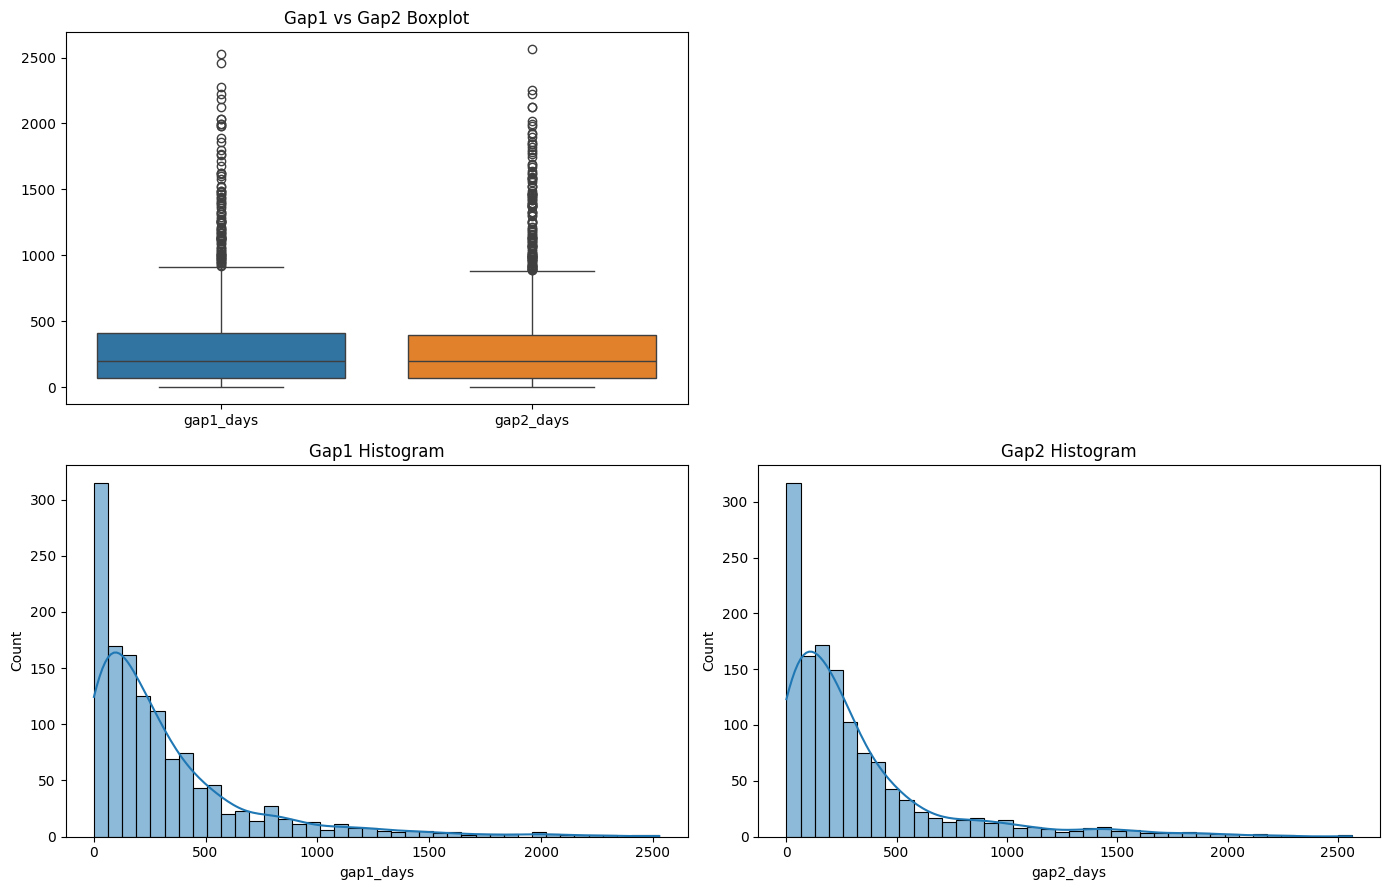

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

desc_df = df_gaps[['gap1_days', 'gap2_days']].describe().T
desc_df['skewness'] = df_gaps[['gap1_days', 'gap2_days']].skew()
desc_df['kurtosis'] = df_gaps[['gap1_days', 'gap2_days']].kurt()

print(desc_df)
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

sns.boxplot(data=df_gaps[['gap1_days', 'gap2_days']], ax=axes[0, 0])
axes[0, 0].set_title("Gap1 vs Gap2 Boxplot")
axes[0, 1].axis("off") 

sns.histplot(df_gaps['gap1_days'], bins=40, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Gap1 Histogram")

sns.histplot(df_gaps['gap2_days'], bins=40, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Gap2 Histogram")

plt.tight_layout()
plt.show()

**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 從 gap1 與 gap2 的敘述統計結果來看，兩段間隔的統計特性相當接近。兩者的平均數分別約為 316 與 319，皆落在 315 至 320 之間；標準差分別約為 374 與 385，數值偏大，顯示違規間隔長度的變異程度相當高。

- 兩段間隔的最小值皆為 1 天，第一四分位數約為 71 天，中位數約為 200 天，第三四分位數約落在 400 天左右，顯示多數違規間隔集中於一年多以內。然而，最大值則分別達到約 2,528 天與 2,563 天，與第三四分位數相比存在明顯落差。

- 將 gap1 與 gap2 的四分位數、最小值與最大值一併觀察，可發現兩者在分布位置與結構上相當一致，未呈現明顯差異；但分布右側皆存在延伸甚長的尾端，顯示資料具有明顯右偏且具長尾特性的分布型態。

- 偏態與峰態指標進一步支持上述觀察。gap1 與 gap2 的偏態值皆介於約 2.25 至 2.35 之間，顯示分布高度右偏；峰態值則介於約 5.5 至 7 之間，反映資料在中心區域集中、尾端延伸明顯的特性。

- 從箱型圖可觀察到，超過第三四分位數加上 1.5 倍 IQR 的資料點數量相當多，顯示分布右側存在大量極端值。然而，在高度右偏且具長尾特性的分布下，箱型圖以 IQR 為基礎所標示的極端值，可能反映的是分布尾端的結構性特徵，而非真正的離群值，是否屬於離群值仍有待資料轉換後再行檢視。

- 直方圖顯示兩段間隔的分布皆高度右偏，多數資料集中於約 700 天以內，但分布尾端延伸至 2,500 天以上，呈現明顯的長尾分布。

- 綜合敘述統計與圖形觀察結果，可確認 gap1 與 gap2 的分布高度右偏且變異程度大，顯示有進一步檢視資料轉換後分布型態之必要性，以作為後續關聯性分析的參考。

**<font color=seagreen>接著要進行的步驟：</font>**

- 針對 gap1 與 gap2 的間隔天數進行對數轉換，以降低分布右偏與長尾特性對後續分析的影響。

- 於轉換後資料上繪製 gap1 與 gap2 的散佈圖（scatter plot），初步觀察兩次違反間隔之間的關係型態。

- 分別計算 Pearson 相關係數與 Spearman 等級相關係數，比較在轉換前後不同尺度下，兩段間隔之間關聯性的表現差異。

**<font color=mediumseagreen>檢視對數轉換後 gap1 與 gap2 的敘述統計與分布特性</font>**

本步驟將重新檢視 gap1 與 gap2 在進行對數轉換後的敘述統計結果，並搭配偏態與峰態指標，以及箱型圖與直方圖，觀察資料分布是否趨於集中，以及原先的右偏與長尾特性是否有所改善。

           count      mean       std  min       25%       50%       75%  \
log_gap1  1318.0  4.975935  1.521310  0.0  4.262680  5.298317  6.010654   
log_gap2  1318.0  4.978336  1.521892  0.0  4.266176  5.288267  5.981414   

               max  skewness  kurtosis  
log_gap1  7.835184 -0.929984  0.735483  
log_gap2  7.848934 -0.923448  0.767694  


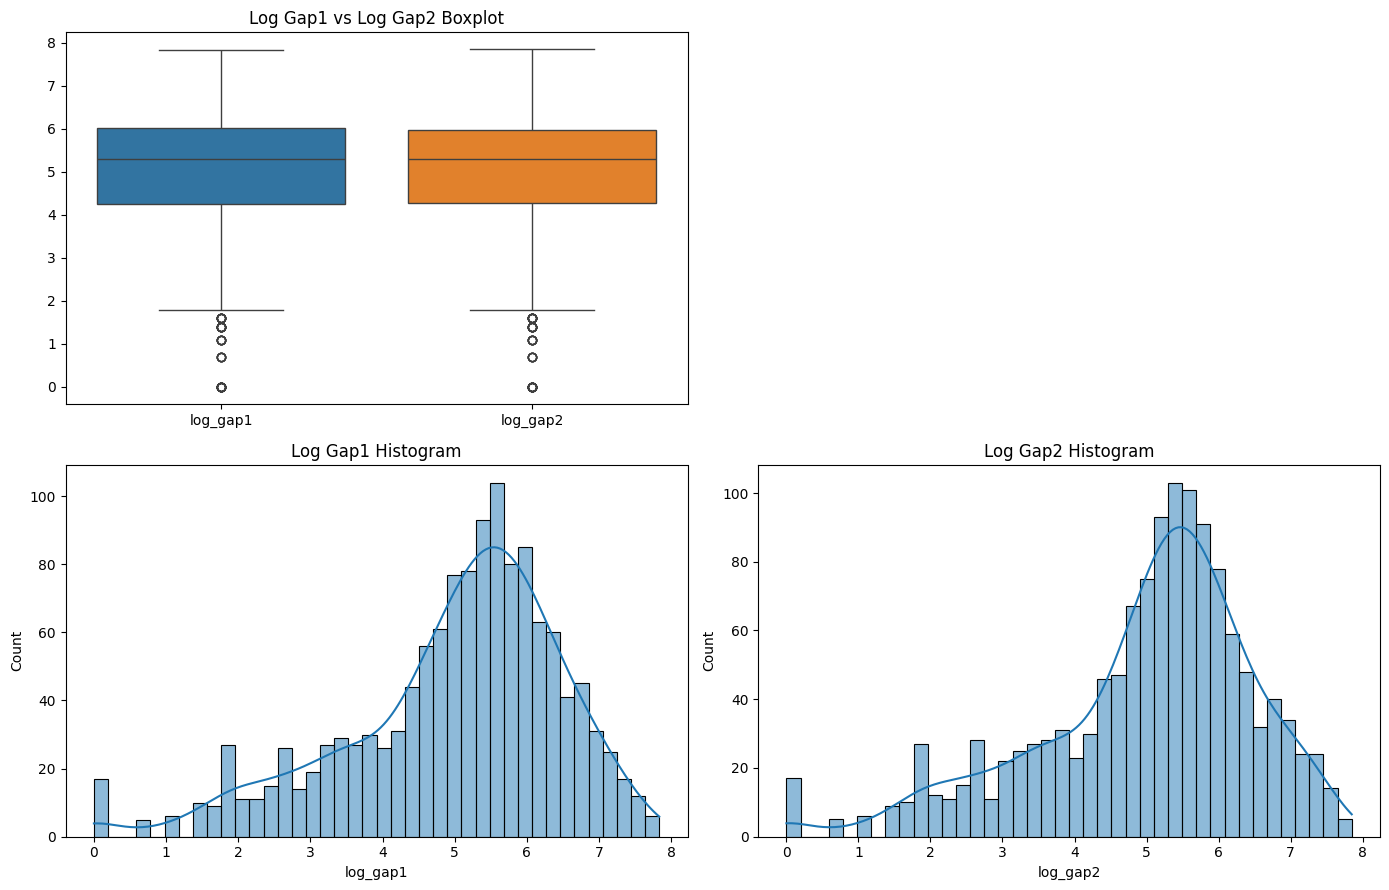

In [ ]:
import numpy as np

df_gaps["log_gap1"] = np.log(df_gaps["gap1_days"])
df_gaps["log_gap2"] = np.log(df_gaps["gap2_days"])

warnings.filterwarnings("ignore", category=FutureWarning)

desc_logdf = df_gaps[['log_gap1', 'log_gap2']].describe().T
desc_logdf['skewness'] = df_gaps[['log_gap1', 'log_gap2']].skew()
desc_logdf['kurtosis'] = df_gaps[['log_gap1', 'log_gap2']].kurt()

print(desc_logdf)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

sns.boxplot(data=df_gaps[['log_gap1', 'log_gap2']], ax=axes[0, 0])
axes[0, 0].set_title("Log Gap1 vs Log Gap2 Boxplot")
axes[0, 1].axis("off")  

sns.histplot(df_gaps['log_gap1'], bins=40, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Log Gap1 Histogram")

sns.histplot(df_gaps['log_gap2'], bins=40, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Log Gap2 Histogram")

plt.tight_layout()
plt.show()

**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 對 gap1 與 gap2 進行對數轉換後，兩者的分布型態出現明顯變化。轉換後的平均數皆約為 4.97，標準差亦同步下降至約 1.52，相較於原始資料，變異程度顯著降低，資料分布更為集中。

- 由四分位數觀察可見，兩個變數的最小值皆為 0，第一四分位數約落在 4.26，中位數約為 5.29，第三四分位數約為 6，而最大值約為 7.84。整體而言，gap1 與 gap2 在對數轉換後的集中趨勢與分布位置高度一致。

- 與原始資料相比，對數轉換後原先明顯的右偏分布已不再出現。然而，從四分位距離與直方圖形狀可觀察到，資料可能呈現輕微左偏，最小值至第一四分位數之間的距離相對較大。

- 偏度與峰度的變化亦支持上述觀察結果。兩個變數的偏度由原本約 2 以上降至約 −1 左右，顯示分布由高度右偏轉為略帶左偏；峰度則由原先約 6 降至約 0.75，分布由高峽峰轉為低闊峰的型態。

- 從箱型圖可見，對數轉換後超出四分位數加減 1.5 倍 IQR 的資料點數量大幅減少，僅剩少數個案，顯示原始資料中大量被標示為極端值的觀察值，多半來自於高度偏態與尺度差異，而非單純的異常資料。

- 直方圖亦顯示，對數轉換後的資料分布雖略呈左偏，但整體形狀較為平滑，且即使位於分布尾端的觀察值，其樣本數仍維持一定比例，呈現較為均勻的分布結構。


### 轉換前後違規間隔之相關性分析

**<font color=seagreen>接著要進行的步驟：</font>**

- 分別以原始間隔資料與對數轉換後的資料，檢視 gap1 與 gap2 之間的關聯性。

- 使用 Pearson 相關係數，評估兩個間隔之間是否存在線性關係。

- 使用 Spearman 等級相關係數，評估兩個間隔之間是否存在單調關係，以降低極端值與分布型態對結果的影響。

- 繪製 gap1 與 gap2 的散佈圖，輔助觀察兩變數之間的關係型態，並比較轉換前後圖形結構之差異。

**<font color=mediumseagreen>計算 gap1 與 gap2 的相關係數並繪製散佈圖（原始資料與對數轉換後）</font>**

本步驟將分別於原始尺度與對數轉換後尺度下計算 Pearson 與 Spearman 相關係數（含 p-value），並以散佈圖輔助檢視兩段間隔的關係型態與轉換前後差異。

                 指標       原始資料      對數轉換後
0           Pearson     0.1925     0.5267
1   Pearson p-value  1.793e-12  5.961e-95
2          Spearman     0.4690     0.4690
3  Spearman p-value  4.880e-73  4.880e-73
4                 n       1318       1318


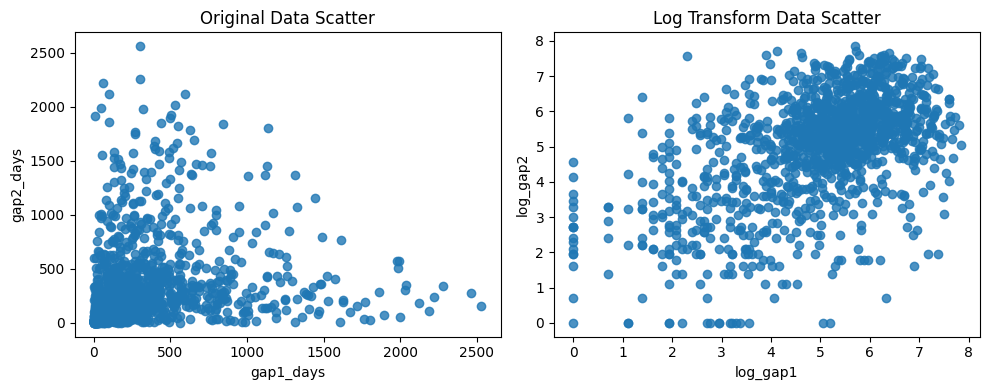

In [68]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

def corr_pack_compact(x, y):
    r, p = pearsonr(x, y)
    s, sp = spearmanr(x, y)
    return (r, p, s, sp, len(x))

r1, p1, s1, sp1, n1 = corr_pack_compact(df_gaps["gap1_days"], df_gaps["gap2_days"])
r2, p2, s2, sp2, n2 = corr_pack_compact(df_gaps["log_gap1"], df_gaps["log_gap2"])

df_corr_compact = pd.DataFrame({
    "指標": ["Pearson", "Pearson p-value", "Spearman", "Spearman p-value", "n"],
    "原始資料": [f"{r1:.4f}", f"{p1:.3e}", f"{s1:.4f}", f"{sp1:.3e}", n1],
    "對數轉換後": [f"{r2:.4f}", f"{p2:.3e}", f"{s2:.4f}", f"{sp2:.3e}", n2],
})

print(df_corr_compact)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.regplot(x="gap1_days", y="gap2_days", data=df_gaps, fit_reg=False, ax=axes[0])
axes[0].set_title("Original Data Scatter")
sns.regplot(x="log_gap1", y="log_gap2", data=df_gaps, fit_reg=False, ax=axes[1])
axes[1].set_title("Log Transform Data Scatter")
plt.tight_layout()
plt.show()

**<font color=skyblue>對執行結果的觀察紀錄：</font>**

- 觀察 **Pearson 相關係數**。在原始資料下，檢定結果的 *p-value* 為 1.793×10<sup>-12</sup>，顯示 gap1 與 gap2 之間存在顯著的線性關聯。然而，其相關係數僅為 0.193，代表兩者雖具有線性關係，但關聯強度偏弱。

- 從原始資料的散佈圖可觀察到，多數資料點集中於左下角，顯示多數違規間隔天數偏短；隨著 gap1 增大，gap2 的分布較為分散，且高間隔天數的樣本數相對較少，整體呈現受右偏分布影響的非均勻結構。

- 在進行對數轉換後，Pearson 檢定的 *p-value* 進一步下降至 5.961×10<sup>-95</sup>。由於原始資料下即已達顯著水準，*p-value* 的進一步縮小主要反映樣本量與關聯一致性，實質解讀上仍以相關係數為主。

- 對數轉換後的 Pearson 相關係數提升至 0.527，顯示兩段違規間隔之間的線性關係明顯增強，已達中度線性相關。相較於原始資料，此結果顯示對數轉換有效降低右偏分布對線性關係估計的干擾。

- 從對數轉換後的散佈圖可見，資料點由左下方向右上呈現較為明確的上升趨勢，顯示 gap1 增加時，gap2 亦傾向隨之增加；雖然在右上區域仍可觀察到資料集中現象，但整體趨勢較原始尺度下清晰許多。

- 觀察 **Spearman 等級相關係數**。無論在原始資料或對數轉換後資料中，Spearman 的相關係數皆為 0.469，*p-value* 為 4.880×10⁻⁷³，顯示兩段間隔之間存在穩定的中度單調關係。

- 由於 Spearman 相關係數係根據資料排序（rank）進行計算，而對數轉換屬於一對一且單調遞增的轉換方式，不會改變資料點的相對排序，因此在轉換前後，Spearman 的相關係數與顯著性結果維持一致，符合方法上的預期。


### 違反第32條之連續違規間隔關聯性之延伸分析

- 本研究針對已知至少三次違反勞基法第32條之負責人，分析其連續違規間隔（gap1 與 gap2）之關聯性。結果顯示，在原始資料尺度下，兩段間隔之間已存在顯著但偏弱的線性關聯；經對數轉換後，線性相關程度明顯提升，達中度線性關係。

- 另一方面，Spearman 等級相關係數在轉換前後皆顯示 gap1 與 gap2 之間具有穩定的中度單調關聯，顯示兩段間隔在排序層級上具一致的變動趨勢。

- 整體而言，分析結果顯示在「已多次違反第32條」的條件下，前一次與後一次違規間隔之長短並非彼此獨立，而具有一定程度的關聯性。

- 本延伸分析之目的在於回應排序型 Pattern Mining 所揭示的重複違規結構，確認其對應的時間間隔是否具有系統性關聯；在此目的達成後，後續分析即止於關聯性層級，以維持本研究以 Pattern Mining 為主軸的整體聚焦。

# 總結與討論

本專題以勞動基準法違規裁罰資料作為分析對象，資料內容涵蓋事業單位或負責人、主管機關、處分日期、公告日期，以及違反之法規條文等資訊。原始資料在未經前處理前共包含 63,840 筆紀錄，具備資料量大、違規行為重複性高，以及法規條文組合多樣等特性，適合用以探討違規行為中潛藏的結構性模式。

基於資料內容的性質，本研究聚焦於「違法法規法條」欄位，嘗試透過 Pattern Mining 方法，系統性地分析不同法條之間的共現關係，並進一步結合時間資訊，檢視違規行為在時間序列上的重複與延續特性。此分析設計旨在從資料本身出發，探索違規行為是否存在穩定且可解釋的模式結構，而非僅止於單一法條或單次違規事件的描述。

在非排序資料的分析中，本研究分別使用 Apriori 與 FP-Growth 進行 Pattern Mining，結果顯示兩種方法在相同參數設定下產生一致的關聯規則，顯示結果具有穩定性。所挖掘出的核心法條多圍繞於勞基法第24條（加班費給付），並與第22條（工資給付）、第30條（正常工時）、第32條（延長工時）、第36條（例假與休息日）、第38條（特別休假）及第39條（假日工資）等條文形成共現結構。從法條內容觀察可發現，未依法給付加班費的事業單位，往往同時伴隨超時工作、假日出勤或未依法給薪等違規情形，非排序 Pattern Mining 有效揭示了違規行為在法條層級上的共現關係。

進一步納入時間順序後，本研究使用 PrefixSpan 進行排序型 Pattern Mining，聚焦於同一負責人在不同日期重複違反法條的行為模式。相較於非排序分析僅能辨識「是否曾違反過」，排序式分析能進一步呈現「如何、以及以何種順序重複違反」。分析結果顯示，「勞基法第32條」存在明顯的連續違反現象，包括連續兩次甚至三次違反的序列，並與第24條之間形成雙向的先後關係。此結果顯示，在實務上，超時工作與未依法給付加班費可能交互出現，且部分事業單位在遭裁罰後仍持續重複違規。

基於排序型 Pattern Mining 所揭示之連續違規結構，本研究進一步進行延伸分析，檢視連續違反第32條時，前後兩次違規間隔是否存在關聯性。首先透過卡方獨立性檢定，以分類後的間隔資料進行粗略檢視，結果顯示兩段間隔並非獨立；在此基礎上，再進一步以 Pearson 與 Spearman 相關係數分析原始資料與對數轉換後資料的關聯特性。分析結果顯示，兩段違規間隔之間存在穩定的單調關聯，且在經對數轉換後，線性關聯程度亦明顯提升。

本研究進行上述統計檢視的目的，在於驗證排序型 Pattern Mining 所挖掘之連續違規模式，是否對應實際的時間行為結構。在確認前後違規間隔之間具有關聯性後，延伸分析已能充分支撐 Pattern Mining 所揭示的結果。考量本專題之核心仍在於資料探勘方法的應用與違規模式的探索，若進一步延伸至模型建構或行為預測，將使研究重心偏離原先的分析主軸，因此本研究選擇在關聯性層級收斂分析，作為整體資料探勘流程的收尾。